# Load scores

In [15]:
%matplotlib inline 

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import csv
from scipy.stats import wasserstein_distance
from matplotlib.ticker import FuncFormatter

# Load output similarities

In [2]:
root = "/scores"
plot_dir = "/plots"

H_fpaths = [
    f"{root}/asset/val_val.csv",
    f"{root}/writingPrompts/test_test_100.csv",
    f"{root}/dailydialog++/dev_dev.csv",
    f"{root}/newstest2014/wmt14-en-de_wmt14-en-de.csv",    
]
C_asset_fpaths = [
    f"{root}/asset/flanT5_large_finetuned-ancestral-val_val.csv",
    f"{root}/asset/flanT5_large_finetuned-nucleus_09-val_val.csv",
    f"{root}/asset/flanT5_large_finetuned-nucleus_095-val_val.csv",
    f"{root}/asset/flanT5_large_finetuned-typical_02-val_val.csv",
    f"{root}/asset/flanT5_large_finetuned-typical_095-val_val.csv",
] 
M_asset_fpaths = [
    f"{root}/asset/flanT5_large_finetuned-ancestral-val_flanT5_large_finetuned-ancestral-val.csv",
    f"{root}/asset/flanT5_large_finetuned-nucleus_09-val_flanT5_large_finetuned-nucleus_09-val.csv",
    f"{root}/asset/flanT5_large_finetuned-nucleus_095-val_flanT5_large_finetuned-nucleus_095-val.csv",
    f"{root}/asset/flanT5_large_finetuned-typical_02-val_flanT5_large_finetuned-typical_02-val.csv",
    f"{root}/asset/flanT5_large_finetuned-typical_095-val_flanT5_large_finetuned-typical_095-val.csv",
]

C_dialogue_fpaths = [
    f"{root}/dailydialog++/dialogpt_large-ancestral-dev_dev.csv",
    f"{root}/dailydialog++/dialogpt_large-nucleus_09-dev_dev.csv",
    f"{root}/dailydialog++/dialogpt_large-nucleus_095-dev_dev.csv",
    f"{root}/dailydialog++/dialogpt_large-top_k_30-dev_dev.csv",
    f"{root}/dailydialog++/dialogpt_large-top_k_40-dev_dev.csv",
    f"{root}/dailydialog++/dialogpt_large-typical_02-dev_dev.csv",
    f"{root}/dailydialog++/dialogpt_large-typical_095-dev_dev.csv",
]
M_dialogue_fpaths = [
    f"{root}/dailydialog++/dialogpt_large-ancestral-dev_dialogpt_large-ancestral-dev.csv",
    f"{root}/dailydialog++/dialogpt_large-nucleus_09-dev_dialogpt_large-nucleus_09-dev.csv",
    f"{root}/dailydialog++/dialogpt_large-nucleus_095-dev_dialogpt_large-nucleus_095-dev.csv",
    f"{root}/dailydialog++/dialogpt_large-top_k_30-dev_dialogpt_large-top_k_30-dev.csv",
    f"{root}/dailydialog++/dialogpt_large-top_k_40-dev_dialogpt_large-top_k_40-dev.csv",
    f"{root}/dailydialog++/dialogpt_large-typical_02-dev_dialogpt_large-typical_02-dev.csv",
    f"{root}/dailydialog++/dialogpt_large-typical_095-dev_dialogpt_large-typical_095-dev.csv",
]

C_storygen_fpaths = [
    f'{root}/writingPrompts/gpt2_large_finetuned-ancestral-test_test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-nucleus_09-test_test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-nucleus_095-test_test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-temperature05-test_test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-typical_02-test_test_100.csv',
]
M_storygen_fpaths = [
    f'{root}/writingPrompts/gpt2_large_finetuned-ancestral-test_gpt2_large_finetuned-ancestral-test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-nucleus_09-test_gpt2_large_finetuned-nucleus_09-test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-nucleus_095-test_gpt2_large_finetuned-nucleus_095-test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-temperature05-test_gpt2_large_finetuned-temperature05-test_100.csv',
    f'{root}/writingPrompts/gpt2_large_finetuned-typical_02-test_gpt2_large_finetuned-typical_02-test_100.csv',
]
C_mt_fpaths = [
    f'{root}/newstest2014/opus-ancestral_wmt14-en-de.csv',
    f'{root}/newstest2014/opus-nucleus_085_wmt14-en-de.csv',
    f'{root}/newstest2014/opus-nucleus_09_wmt14-en-de.csv',
    f'{root}/newstest2014/opus-temperature05_wmt14-en-de.csv',
    f'{root}/newstest2014/opus-temperature075_wmt14-en-de.csv',
    f'{root}/newstest2014/opus-top_k_30_wmt14-en-de.csv',
    f'{root}/newstest2014/opus-top_k_40_wmt14-en-de.csv',
]
M_mt_fpaths = [
    f'{root}/newstest2014/opus-ancestral_opus-ancestral.csv',
    f'{root}/newstest2014/opus-nucleus_085_opus-nucleus_085.csv',
    f'{root}/newstest2014/opus-nucleus_09_opus-nucleus_09.csv',
    f'{root}/newstest2014/opus-temperature05_opus-temperature05.csv',
    f'{root}/newstest2014/opus-temperature075_opus-temperature075.csv',
    f'{root}/newstest2014/opus-top_k_30_opus-top_k_30.csv',
    f'{root}/newstest2014/opus-top_k_40_opus-top_k_40.csv',
]
C_fpaths = C_asset_fpaths + C_dialogue_fpaths + C_storygen_fpaths + C_mt_fpaths
M_fpaths = M_asset_fpaths + M_dialogue_fpaths + M_storygen_fpaths + M_mt_fpaths

# Load all similarities into a big dataframe (and transform them into distances)

In [3]:
def construct_df(fpaths):
    n_tgts = 10
    n_cands = 10
    schema = {
            "task": str, #0
            "cand_system": str, #1
            "tgt_system": str, #2
            "score_name": str, #3
            "context_id": int, #4
            "candidate_id": float, #5 
            "target_id": float,  #6 
            "score_value": float #7
    }
    valid_score_names = [
        "1gram_overlap_yy", "2gram_overlap_yy", "3gram_overlap_yy",
        "1gram_pos_overlap_yy", "2gram_pos_overlap_yy", "3gram_pos_overlap_yy",
        "cosine_similarity_yy"
    ]
    scores = list()
    for fpath in fpaths:
        with open(fpath, "r") as f:
            reader = csv.reader(f)
            column_names = next(reader)
            scores += [
                r for r in reader
                # read all score rows with n_responses lower than n_tgts or n_cands
                if (
                    ((r[5] == "nan") or int(r[5]) <= n_tgts) # nan for context length score
                    and ((r[6] == "nan") or (int(r[6]) <= n_cands)) # nan for length or context-response scores
                    and (r[3] in valid_score_names)
                )
            ]
    df = pd.DataFrame(data=scores, columns=column_names)
    df = df.astype(schema)
    
    # From similarity/overlap to distance
    df["score_value"] = 1 - df["score_value"]

    # Prettify names
    df["cand_system"] = df['cand_system'].replace(
        {'val':'human', "dev": "human", "test": "human", "wmt14-en-de": "human"}
    )
    df["task"] = df['task'].replace(
        {
            'asset':'Simplification', 
            "newstest2014": "Translation", 
            "writingPrompts": "Story Generation", 
            "dailydialog++": "Open-Domain Dialogue"
        }
    )
    score_mapping = {
            '1gram_overlap_yy': "Unigram distance",
            '1gram_pos_overlap_yy': "POS unigram distance",
            '2gram_overlap_yy': "Bigram distance",
            '2gram_pos_overlap_yy': "POS bigram distance",
            '3gram_overlap_yy': "Trigram distance",
            '3gram_pos_overlap_yy': "POS trigram distance",
            'cosine_similarity_yy': "Cosine distance"
    }
    df["score_name"] = df['score_name'].replace(score_mapping)
    return df

df_H = construct_df(H_fpaths)
print("Loaded df_H")
df_C = construct_df(C_fpaths)
print("Loaded df_C")
df_M = construct_df(M_fpaths)
print("Loaded df_M")

Loaded df_H
Loaded df_C
Loaded df_M


# Human Production Variability H(X)

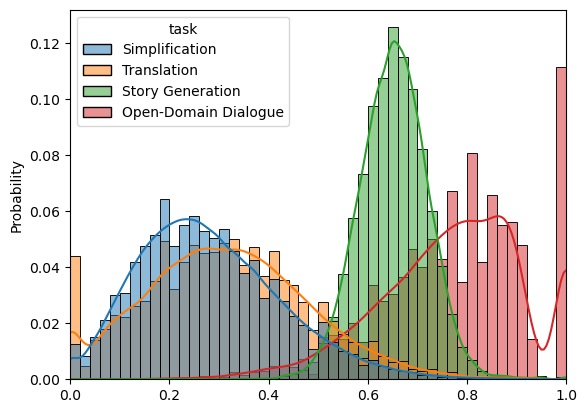

In [7]:
def plot_human(df, score_names, n_bins=50):
    fig, axes = plt.subplots(nrows=1, ncols=len(score_names))
    for i, score_name in enumerate(score_names):
        plot_df = df[
            (df["score_name"] == score_name) & 
            (df["cand_system"] == "human") 
        ]
        ax = axes if len(score_names) == 1 else axes[i]
        sns.histplot(
            plot_df,
            x="score_value", 
            hue="task", 
            bins=np.linspace(0,1,num=n_bins+1), 
            kde=True,
            stat="probability",
            ax=ax,
            common_norm=False,
            hue_order=["Simplification", "Translation", "Story Generation", "Open-Domain Dialogue"]
        )
        ax.set_xlabel('')  #(score_name)
        ax.set_xlim((0,1))       
        # fig.savefig(f"{plot_dir}/human_{score_name.replace(' ', '_')}.png")
#         fig.suptitle("Semantic" if "sim" in score_name else "Syntactic" if "POS" in score_name else "Lexical")

plot_human(df_H, ["Unigram distance"])
# plot_human(df_H, ["Bigram distance"])
# plot_human(df_H, ["Trigram distance"])
# plot_human(df_H, ["POS unigram distance"])
# plot_human(df_H, ["POS bigram distance"])
# plot_human(df_H, ["POS trigram distance"])
# plot_human(df_H, ["Cosine distance"])

# Conditional Fitness 

In [5]:
def conditional_fitness(df_human, df, x_min, x_max, n_bins=50, do_plot=False, do_control=True):
    """
    1. Make two disjoint samples from H(x): H_1(x) and H_2(x) for each input x.
    2. Compute divergence D(H_1(x), H_2(x)) for each input x for each probe to appreciate 
        a plausible divergence curve between two human-based processes.
    3. Compute divergence D(C(x), H_1(x)) or D(M(x), H_1(x)) for each input x for each system/probe
    (3.1. Optionally also compute D(M(x), H(x)))
    4. Plot distribution over divergence scores D for all x for 2 and 3
    5. Summarise divergence curves from (2) and (3)
    
    Args:
        df_human: Variability between human outputs (in terms of distances)
        df: Variability between system outputs and themselves (self-variability) or human outputs (cross-variability).
            Contains distance scores for a single task for multiple NLG systems and probes.
    Returns:
        A (task, comparison) dataframe with a scalar summary of the divergence between the 
        divergence distribution for each (system, probe) pair w.r.t. human distances, 
        and human-human divergences.
    """
    system_names = list(df.cand_system.unique())
    score_names = list(df.score_name.unique())
    
    df_Dmu_S_H1 = pd.DataFrame(columns=score_names, index=system_names + ["human_control"] if do_control else [])
    df_Dw_S_H1 = pd.DataFrame(columns=score_names, index=system_names + ["human_control"] if do_control else [])
    
    if do_plot:
        fig, axes = plt.subplots(nrows=len(system_names), ncols=len(score_names), figsize=(50, 5*len(system_names)))
        fig.tight_layout()
        
    for j, system_name in enumerate(system_names): # excludes human_control
        for i, score_name in enumerate(score_names):
            # Fetch output distances for one system/probe
            df_system_score = df[(
                (df["score_name"] == score_name) &
                (df["cand_system"] == system_name) 
            )]
            df_human_score = df_human[(df_human["score_name"] == score_name)]

            # Extract (system, probe) output distances in a list per input
            df_system_score = df_system_score\
                .groupby(["task", "cand_system", "tgt_system", "score_name","context_id"], as_index=False)\
                .agg({"score_value" : lambda x: list(x)})
            df_human_score = df_human_score\
                .groupby(["task", "cand_system", "tgt_system", "score_name","context_id"], as_index=False)\
                .agg({"score_value" : lambda x: list(x)})

            Dmu_S_H1 = list()
            Dw_S_H1 = list()
            Dmu_H1_H2 = list() # the control distance will be the same for each system
            Dw_H1_H2 = list() # the control distance will be the same for each system
            
            # Obtain each input row
            for _, input_row_sys in df_system_score.iterrows():
                # Extract C(x)
                model_distances = np.nan_to_num(input_row_sys["score_value"])

                # Extract H(x) and make sure it is aligned with the input order of the system
                human_distances = np.nan_to_num(df_human_score[
                        (df_human_score["context_id"] == input_row_sys["context_id"])
                    ]["score_value"].tolist()[0])
                
                # Split H(x) into H_1(x) and H_2(x) (Step 1)
                rng = np.random.default_rng(42)
                random_indices = rng.choice(np.arange(len(human_distances)), len(human_distances))
                h1_distances = human_distances[random_indices[:len(random_indices)//2]]
                h2_distances = human_distances[:len(random_indices)//2]
                
                # Compute human to human "control" divergence D(H_1(x), H_2(x)) (Step 2)
                if do_control:
                    Dw_H1_H2.append(wasserstein_distance(h1_distances, h2_distances))
                    Dmu_H1_H2.append(np.mean(h1_distances) - np.mean(h2_distances))
                
                # Compute system to human divergence D(., H_1(x)) (Step 3)
                Dw_S_H1.append(
                    wasserstein_distance(model_distances, h1_distances if do_control else human_distances)
                )
                Dmu_S_H1.append(
                    np.mean(model_distances) - np.mean(h1_distances if do_control else human_distances)
                )

            if do_plot: # Step (4)
                model_dist = pd.DataFrame(columns=["cand_system", "wasserstein_distance"])
                model_dist["wasserstein_distance"] = Dw_S_H1
                model_dist["cand_system"] = system_name            
                human_dist = pd.DataFrame(columns=["cand_system", "wasserstein_distance"])
                human_dist["wasserstein_distance"] = Dw_H1_H2
                human_dist["cand_system"] = "human"
                concat = pd.concat([model_dist, human_dist], axis=0).reset_index()
                sns.histplot(
                    data=concat,
                    x=f"wasserstein_distance", 
                    hue="cand_system", 
                    bins=np.linspace(x_min,x_max,num=n_bins+1), 
                    kde=True,
                    stat="probability",
                    ax=axes[j, i],
                    common_norm=False,
                )
                axes[j, i].set_xlabel(score_name)
                axes[j, i].set_xlim((x_min, x_max))   
                dim = "Semantic" if "sim" in score_name else "Syntactic" if "POS" in score_name else "Lexical"
                axes[j, i].set_title(f"{dim} Model Production Variability")  

            # Compute mean of divergence distributions (Step 5)
            df_Dmu_S_H1.loc[system_name, score_name] = Dmu_S_H1
            df_Dw_S_H1.loc[system_name, score_name] = Dw_S_H1
            df_Dmu_S_H1.loc["human_control", score_name] = Dmu_H1_H2
            df_Dw_S_H1.loc["human_control", score_name] = Dw_H1_H2
        
    plt.tight_layout()
    return df_Dmu_S_H1, df_Dw_S_H1

# Effect of Decoding Algorithms (Figure 5 and 9)

D_W(M(x), H(x))
Simplification
Translation
Story Generation
Open-Domain Dialogue


/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/scratch-local/jbaan.4211658/ipykernel_1584069/155437794.py:81: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_mean_divergences.\


D_mu(M(x), H(x))
Simplification
Translation
Story Generation
Open-Domain Dialogue


/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/scratch-local/jbaan.4211658/ipykernel_1584069/155437794.py:81: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_mean_divergences.\


D_W(C(x), H(x))
Simplification
Translation
Story Generation
Open-Domain Dialogue


/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/scratch-local/jbaan.4211658/ipykernel_1584069/155437794.py:81: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_mean_divergences.\


D_mu(C(x), H(x))
Simplification
Translation
Story Generation
Open-Domain Dialogue


/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jbaan/.conda/envs/stat-gen-eval-3.10/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/scratch-local/jbaan.4211658/ipykernel_1584069/155437794.py:81: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional func

<Figure size 640x480 with 0 Axes>

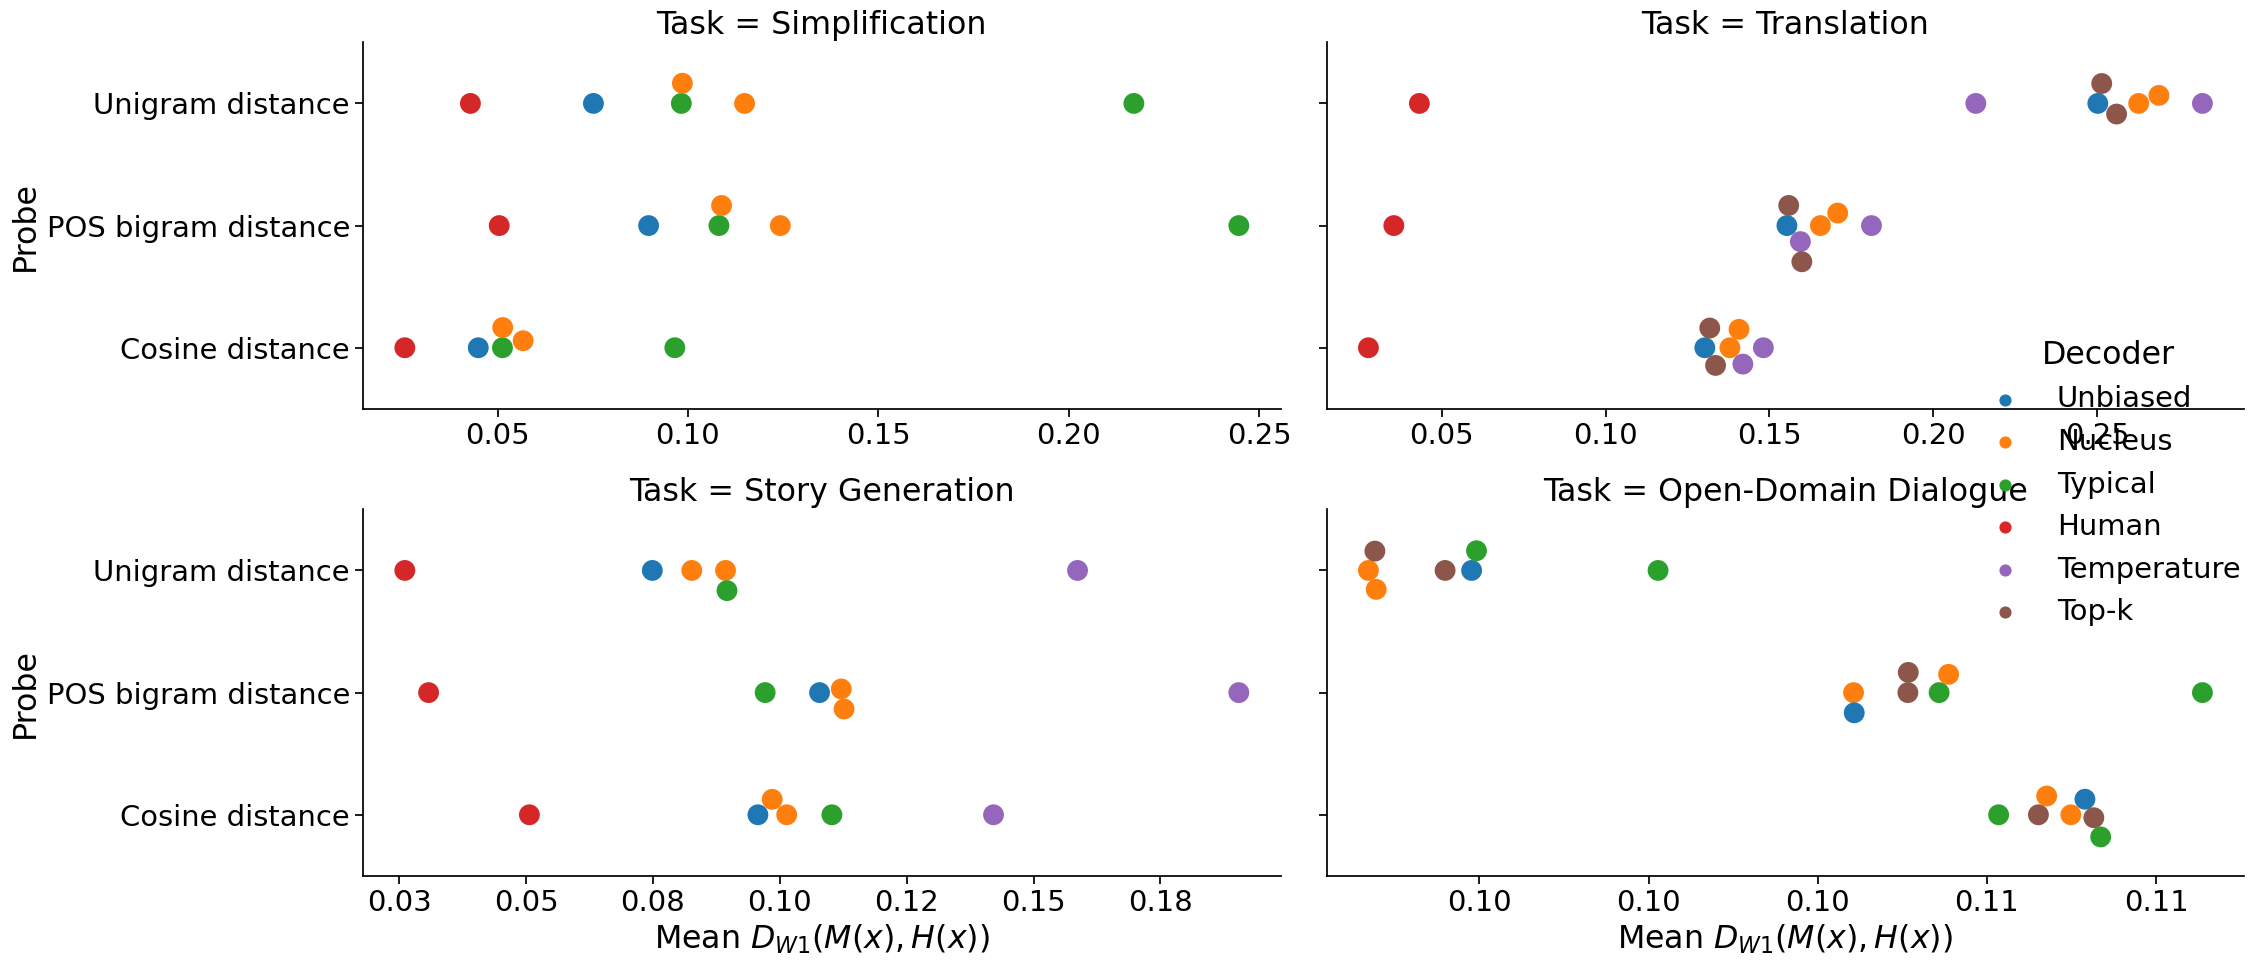

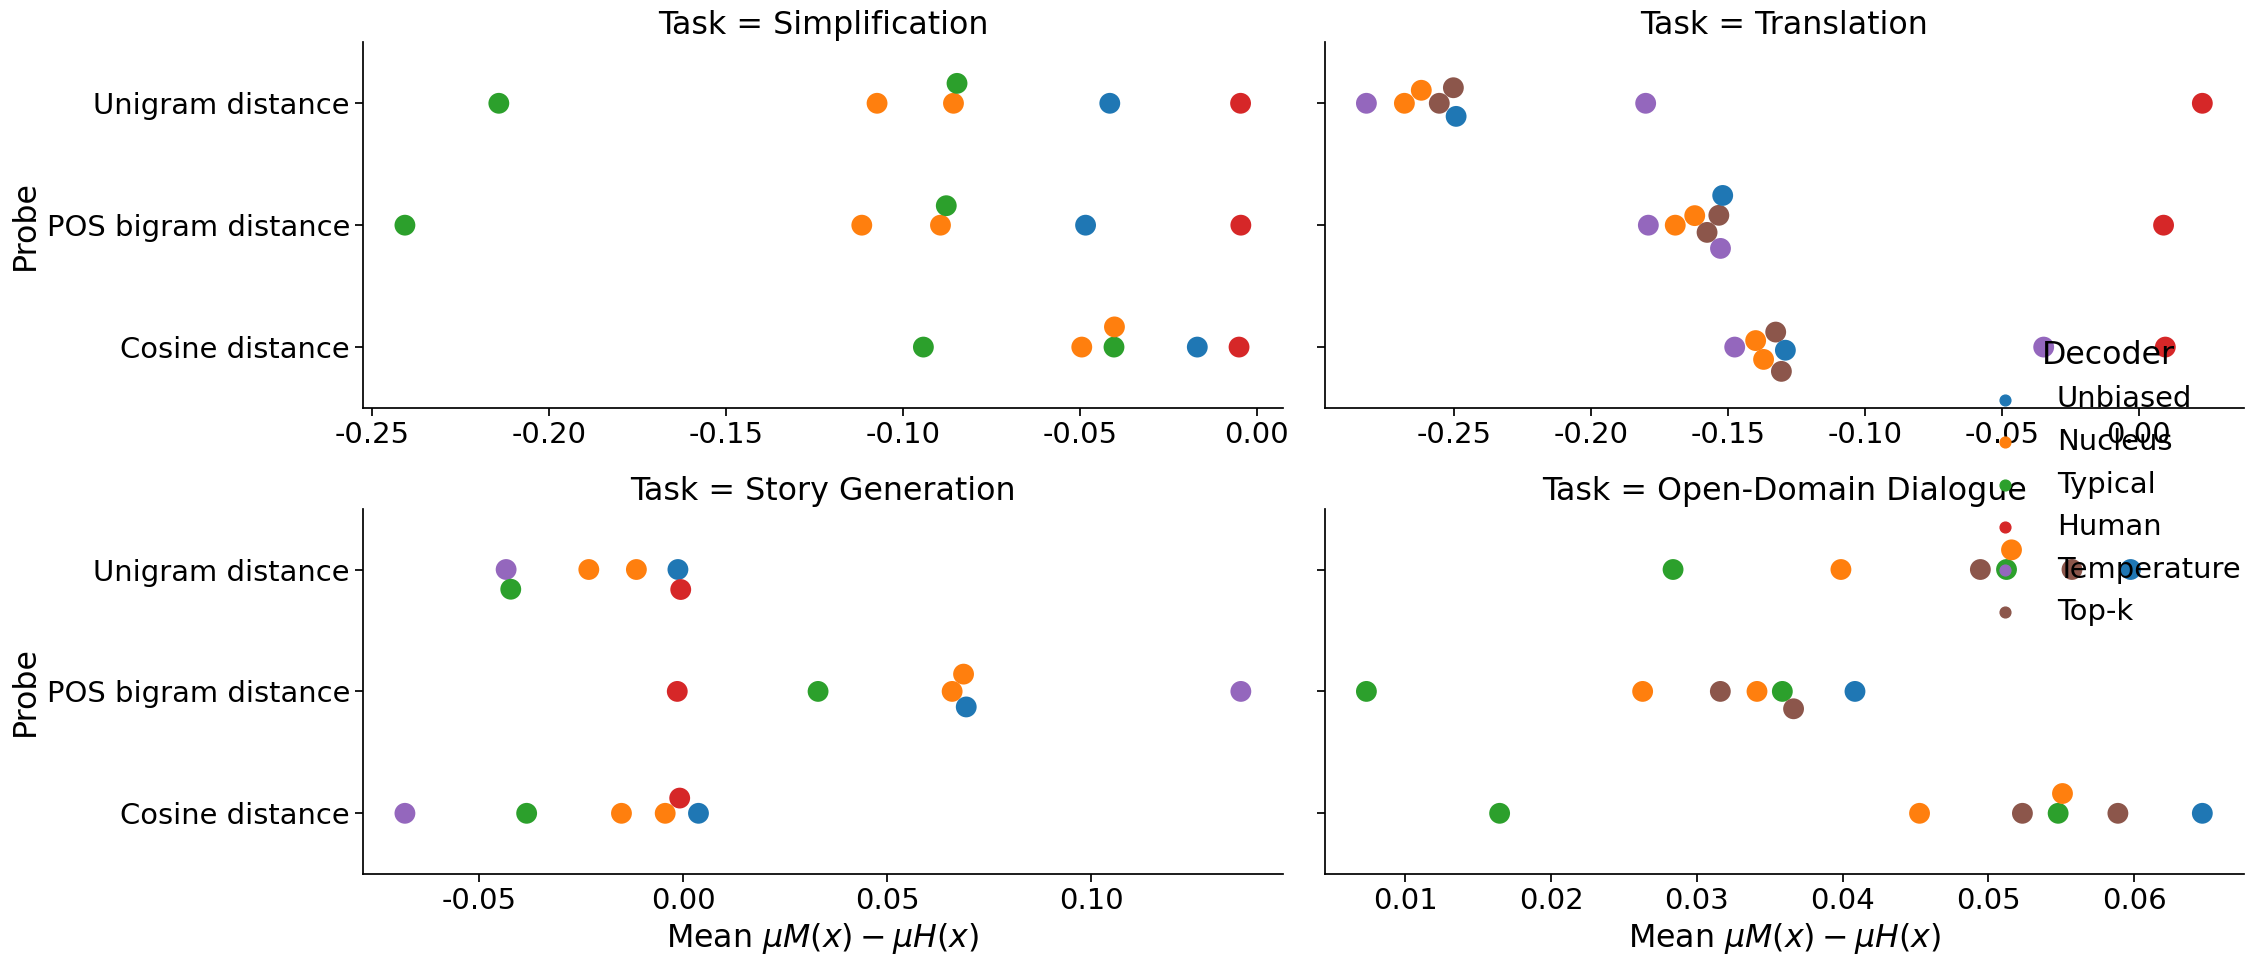

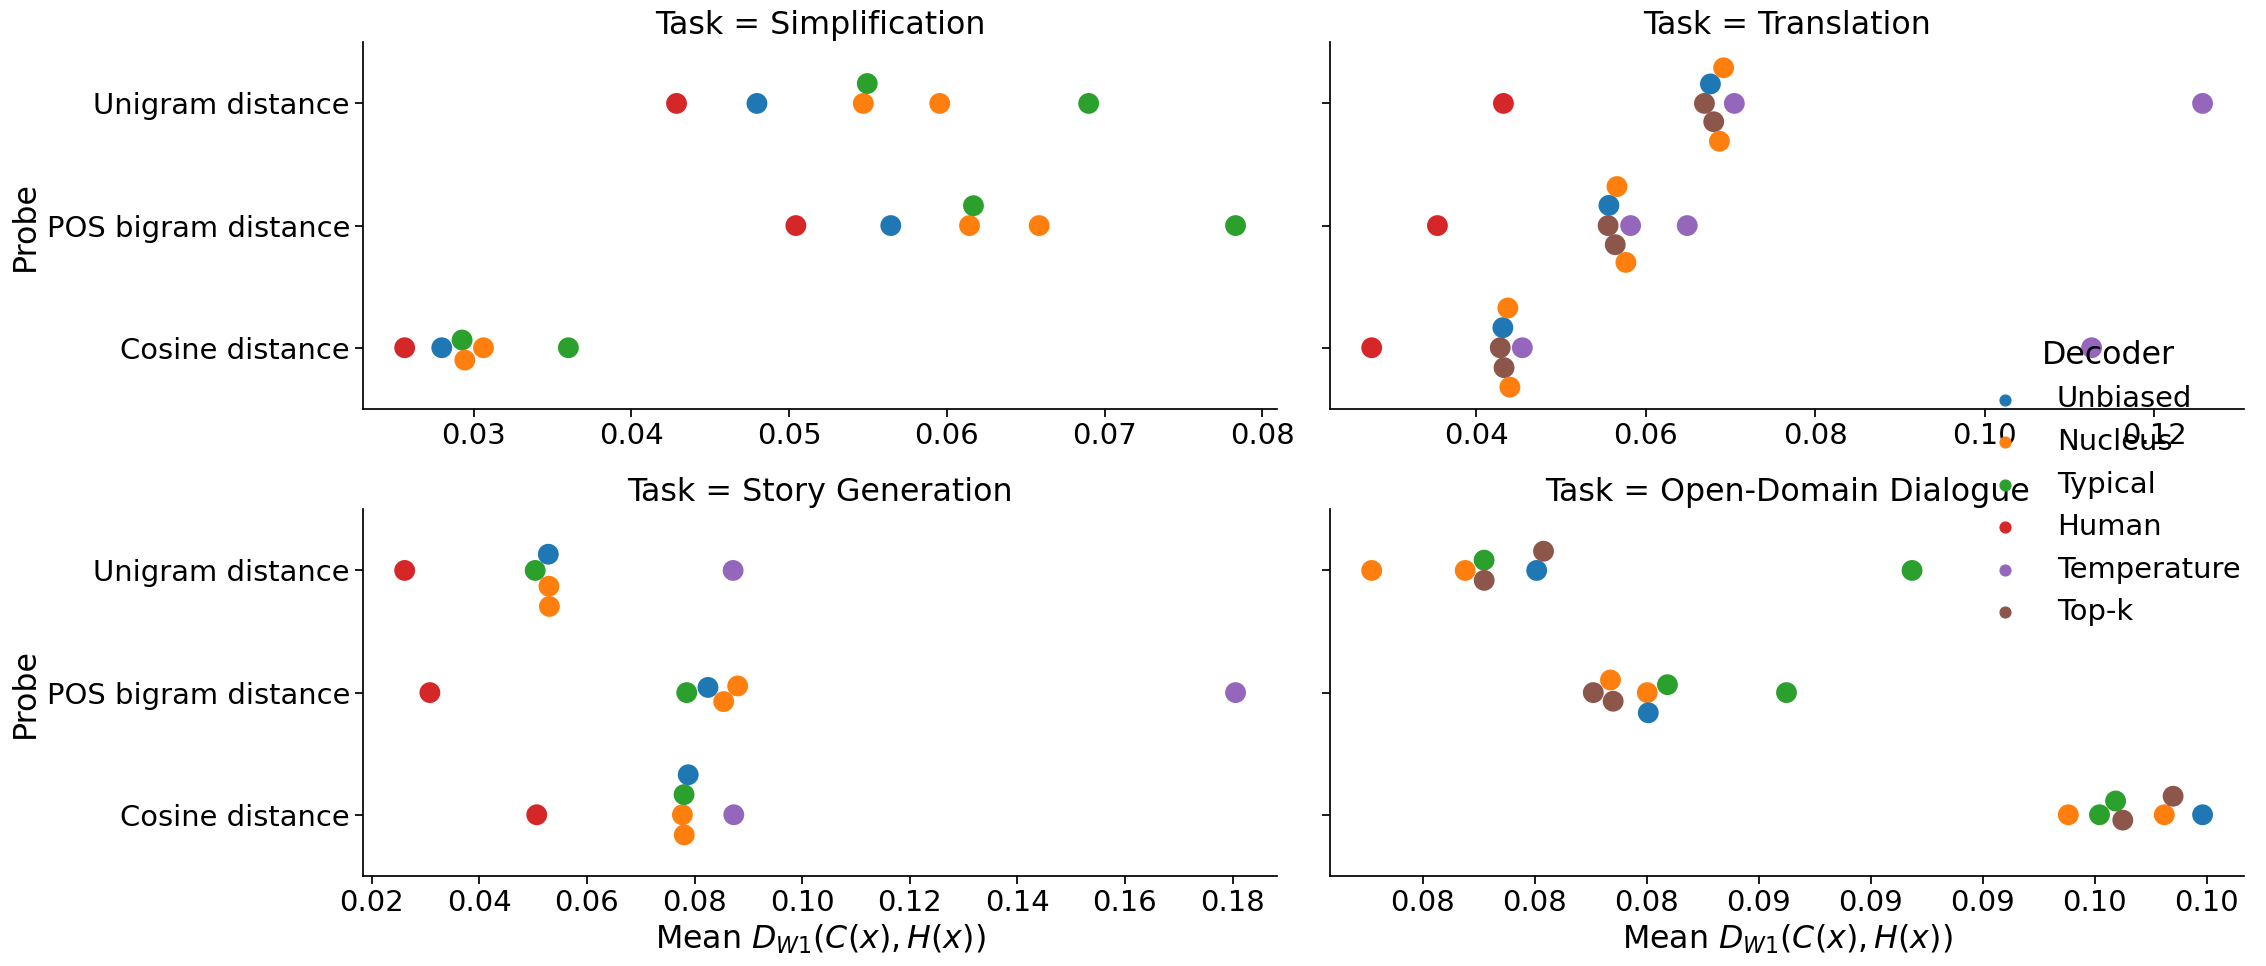

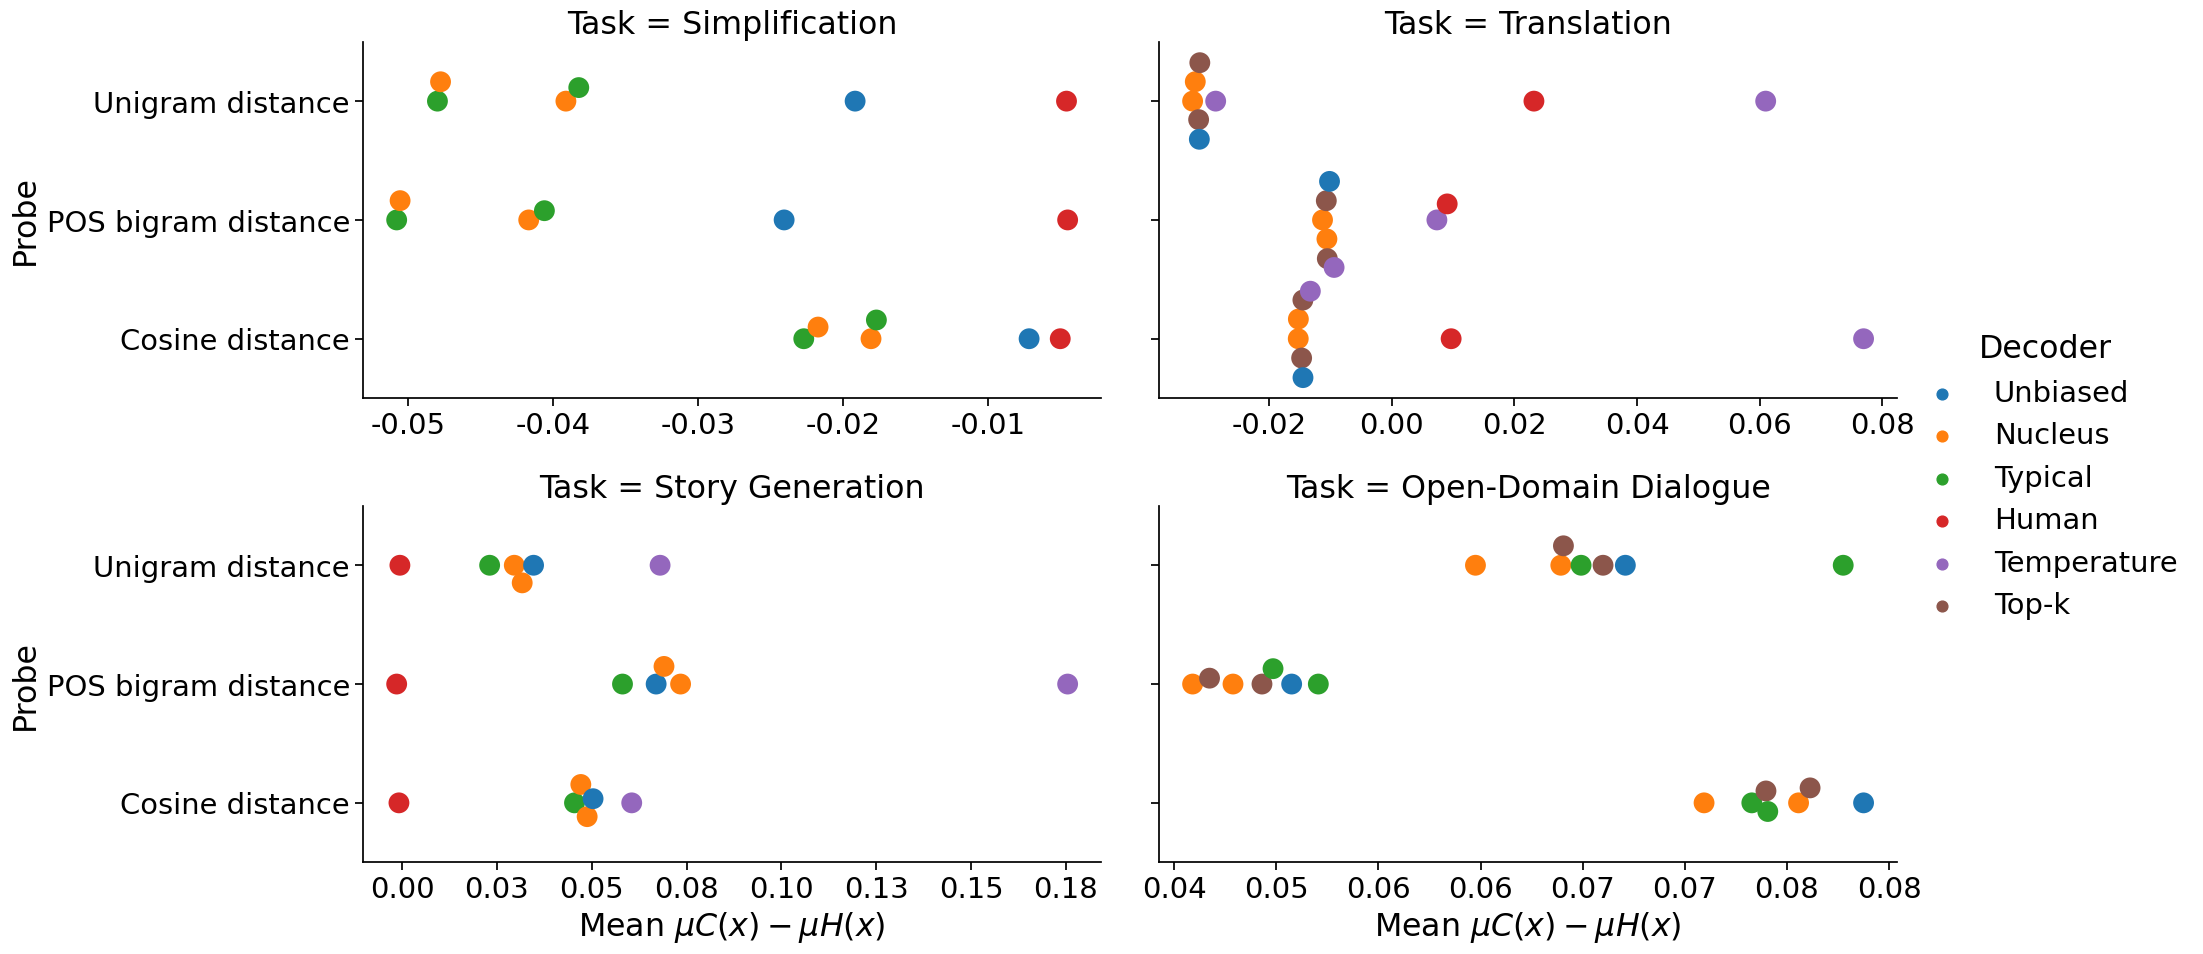

In [18]:
stored_results = dict()
tasks = [
    "Simplification", 
    "Translation", 
    "Story Generation", 
    "Open-Domain Dialogue"
]
for comparison in [
    "self", 
    "cross"
]:
    for divergence_metric in [
        "D_W",
        "D_mu",
    ]:
        mean_divergences = list()
        setting_name = f"{divergence_metric}({'C' if comparison == 'cross' else 'M'}(x), H(x))"
        print(setting_name)
        for task in tasks:
            print(task)
            df_distance_scores = df_C if comparison == "cross" else df_M
            task_mean_divergence = conditional_fitness(
                df_H[df_H["task"]==task], 
                df_distance_scores[df_distance_scores["task"]==task],
                x_min=0, 
                x_max=1,
                do_control=False if task == "Open-Domain Dialogue" else True # too little references
            )[1 if divergence_metric=="D_W" else 0]
            
            # Map each column to the mean of its value
            task_mean_divergence = task_mean_divergence.applymap(lambda x: np.mean(x))
            
            task_mean_divergence["Model"] = task_mean_divergence.index
            task_melted_mean_diverence = pd.melt(
                task_mean_divergence, 
                id_vars=["Model"], 
                value_vars=["Unigram distance", "POS bigram distance", "Cosine distance"],
                value_name=f'Mean {setting_name}',
                var_name='Probe',
            )
            task_melted_mean_diverence["Task"] = task
            task_melted_mean_diverence["Comparison"] = setting_name
            mean_divergences.append(task_melted_mean_diverence)
        df_mean_divergences = pd.concat(mean_divergences)
        patterns = [
            (df_mean_divergences.Model.str.contains('ancestral')), 
            (df_mean_divergences.Model.str.contains('nucleus')),
            (df_mean_divergences.Model.str.contains('typical')),
            (df_mean_divergences.Model.str.contains('temp')),
            (df_mean_divergences.Model.str.contains('top')),
            (df_mean_divergences.Model.str.contains('human_control')),
        ]
        pretty_names = ['Unbiased', 'Nucleus', 'Typical', 'Temperature', 'Top-k', 'Human']
        df_mean_divergences['Decoder'] = np.select(patterns, pretty_names)
        with sns.plotting_context("notebook", font_scale=1.9):
            fg = sns.catplot(
                data=df_mean_divergences, 
                y="Probe",
                x=f"Mean {setting_name}", 
                kind="swarm", 
                col="Task", 
                aspect=2,
                sharex=False,
                col_order=tasks,
                hue="Decoder",
                col_wrap=2,
                s=15
            )
            if setting_name == "D_W(M(x), H(x))":
                fg.set_xlabels(r"Mean $D_{W1}(M(x), H(x))$")
            elif setting_name == "D_mu(M(x), H(x))":
                fg.set_xlabels(r"Mean $\mu M(x) - \mu H(x)$")
            elif setting_name == "D_W(C(x), H(x))":
                fg.set_xlabels(r"Mean $D_{W1}(C(x), H(x))$")
            elif setting_name == "D_mu(C(x), H(x))":
                fg.set_xlabels(r"Mean $\mu C(x) - \mu H(x)$")
            for ax in fg.axes.flat:
                ax.xaxis.set_major_formatter(FuncFormatter(lambda y, p: f'{y:.2f}'))
                
        # Save figures and table to disk 
        latex_table = df_mean_divergences.\
        set_index(df_mean_divergences.Model)[["Probe", f"Mean {setting_name}", "Task"]].\
        to_latex(caption=f"Mean {setting_name} results for different decoding parameters.")
        output_fname = f"{plot_dir}/decoders_{setting_name}"
        fg.savefig(f"{output_fname}.png")
        with open(f'{output_fname}.txt', 'w') as f:
            f.write(latex_table)
        stored_results[f"{setting_name}"] = df_mean_divergences

# Human-Model Alignment of Production Variability (Figure 3 and 7)

In [31]:
H_fpaths = [
    f"{root}/asset/val_val.csv",
    f"{root}/writingPrompts/test_test_100.csv",
    f"{root}/dailydialog++/dev_dev.csv",
    f"{root}/newstest2014/wmt14-en-de_wmt14-en-de.csv",    
]

M_fpaths = [
    f"{root}/asset/flanT5_large_finetuned-ancestral-val_flanT5_large_finetuned-ancestral-val.csv",
    f"{root}/writingPrompts/gpt2_large_finetuned-ancestral-test_gpt2_large_finetuned-ancestral-test_100.csv",
    f"{root}/dailydialog++/dialogpt_medium-ancestral-dev_dialogpt_medium-ancestral-dev.csv",
    f"{root}/newstest2014/opus-ancestral_opus-ancestral.csv",
]

C_fpaths = [
    f"{root}/asset/flanT5_large_finetuned-ancestral-val_val.csv",
    f"{root}/writingPrompts/gpt2_large_finetuned-ancestral-test_test_100.csv",
    f"{root}/dailydialog++/dialogpt_medium-ancestral-dev_dev.csv",
    f'{root}/newstest2014/opus-ancestral_wmt14-en-de.csv',
]
df_H = construct_df(H_fpaths)
df_C = construct_df(C_fpaths)
df_M = construct_df(M_fpaths)

In [33]:
df_divergences = {}
for comparison in ['self', 'cross']:
    comparison_df = df_M if comparison == 'self' else df_C
    dfs = list()
    for task in tasks:
        # compute divergence for each task
        task_mean_divergence = conditional_fitness(
            df_H[df_H["task"]==task],
            comparison_df[comparison_df["task"]==task],
            x_min=0,
            x_max=1,
            do_control=False
            
        )
        # only retrieve difference in means (no Wasserstein distance)
        task_mean_divergence = task_mean_divergence[0]
        # add task label to df and append to other tasks' dfs
        task_mean_divergence["task"] = task
        dfs.append(task_mean_divergence)
    # concatenate all tasks' dfs for this comparison type
    df_divergences[comparison] = pd.concat(dfs)


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_54616/3199360204.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_54616/3199360204.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_54616/3199360204.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_54616/3199360204.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_54616/3199360204.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_54616/3199360204.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel

<Figure size 640x480 with 0 Axes>

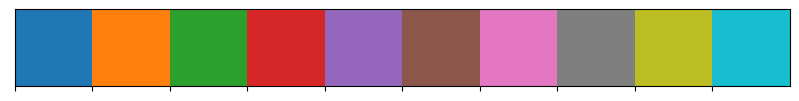

In [17]:
qualitative_colors = sns.color_palette() # ("Set3", 10)
sns.palplot(qualitative_colors)
plt.rcdefaults()
plt.rcParams.update({'font.size': 18})

### Figure 3

In [34]:
# Convenience function for boxplots of mean differences across tasks and probes
# (just like df_divergences['self'] or df_divergences['cross'] created above)

def plot_mean_difference_dist(dist_df, save_path=None):
    """
    Args:
        dist_df: dataframe with mean differences across tasks and probes
        save_path: path to save figure to
    """
    cols = ["Lexical variability", "Syntactic variability", "Semantic variability"]
    xlabels = ["Unigram distance", "POS bigram distance", "Cosine distance"]

    fig, axes = plt.subplots(nrows=4, ncols=len(xlabels), figsize=(26, 9))
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, y=1.15, fontsize=22)

    for i, score_name in enumerate(xlabels):

        # Explode list-valued cells into rows
        columns = dist_df.columns.tolist()
        columns.remove('task')
        tmp_df = dist_df.explode(columns).reset_index(drop=True)
        sns.boxplot(
            data=tmp_df.query("task == 'Translation'"),
            x=score_name,
            ax=axes[0, i],
            color=qualitative_colors[0]
        )
        axes[0, i].set_xlabel("")
        axes[0, i].set_xlim(-0.85,0.85)

        sns.boxplot(
            data=tmp_df.query("task == 'Simplification'"),
            x=score_name,
            ax=axes[1, i],
            color=qualitative_colors[1]
        )
        axes[1, i].set_xlabel("")
        axes[1, i].set_xlim(-0.85,0.85)

        sns.boxplot(
            data=tmp_df.query("task == 'Story Generation'"),
            x=score_name,
            ax=axes[2, i],
            color=qualitative_colors[2]
        )
        axes[2, i].set_xlabel("")
        axes[2, i].set_xlim(-0.85,0.85)

        sns.boxplot(
            data=tmp_df.query("task == 'Open-Domain Dialogue'"),
            x=score_name,
            ax=axes[3, i],
            color=qualitative_colors[3],
        )
        axes[3, i].set_xlabel("")
        axes[3, i].set_xlim(-0.85,0.85)
        axes[3, i].set_xlabel(xlabels[i], labelpad=10, fontsize=18)

    # plt.rcParams.update({'font.size': 16})
    axes[0, 2].legend(["Translation"], loc="upper right", fontsize=18)
    axes[1, 2].legend(["Simplification"], loc="upper right", fontsize=18)
    axes[2, 2].legend(["Stories"], loc="upper right", fontsize=18)
    axes[3, 2].legend(["Dialogue"], loc="upper right", fontsize=18)

    fig.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1

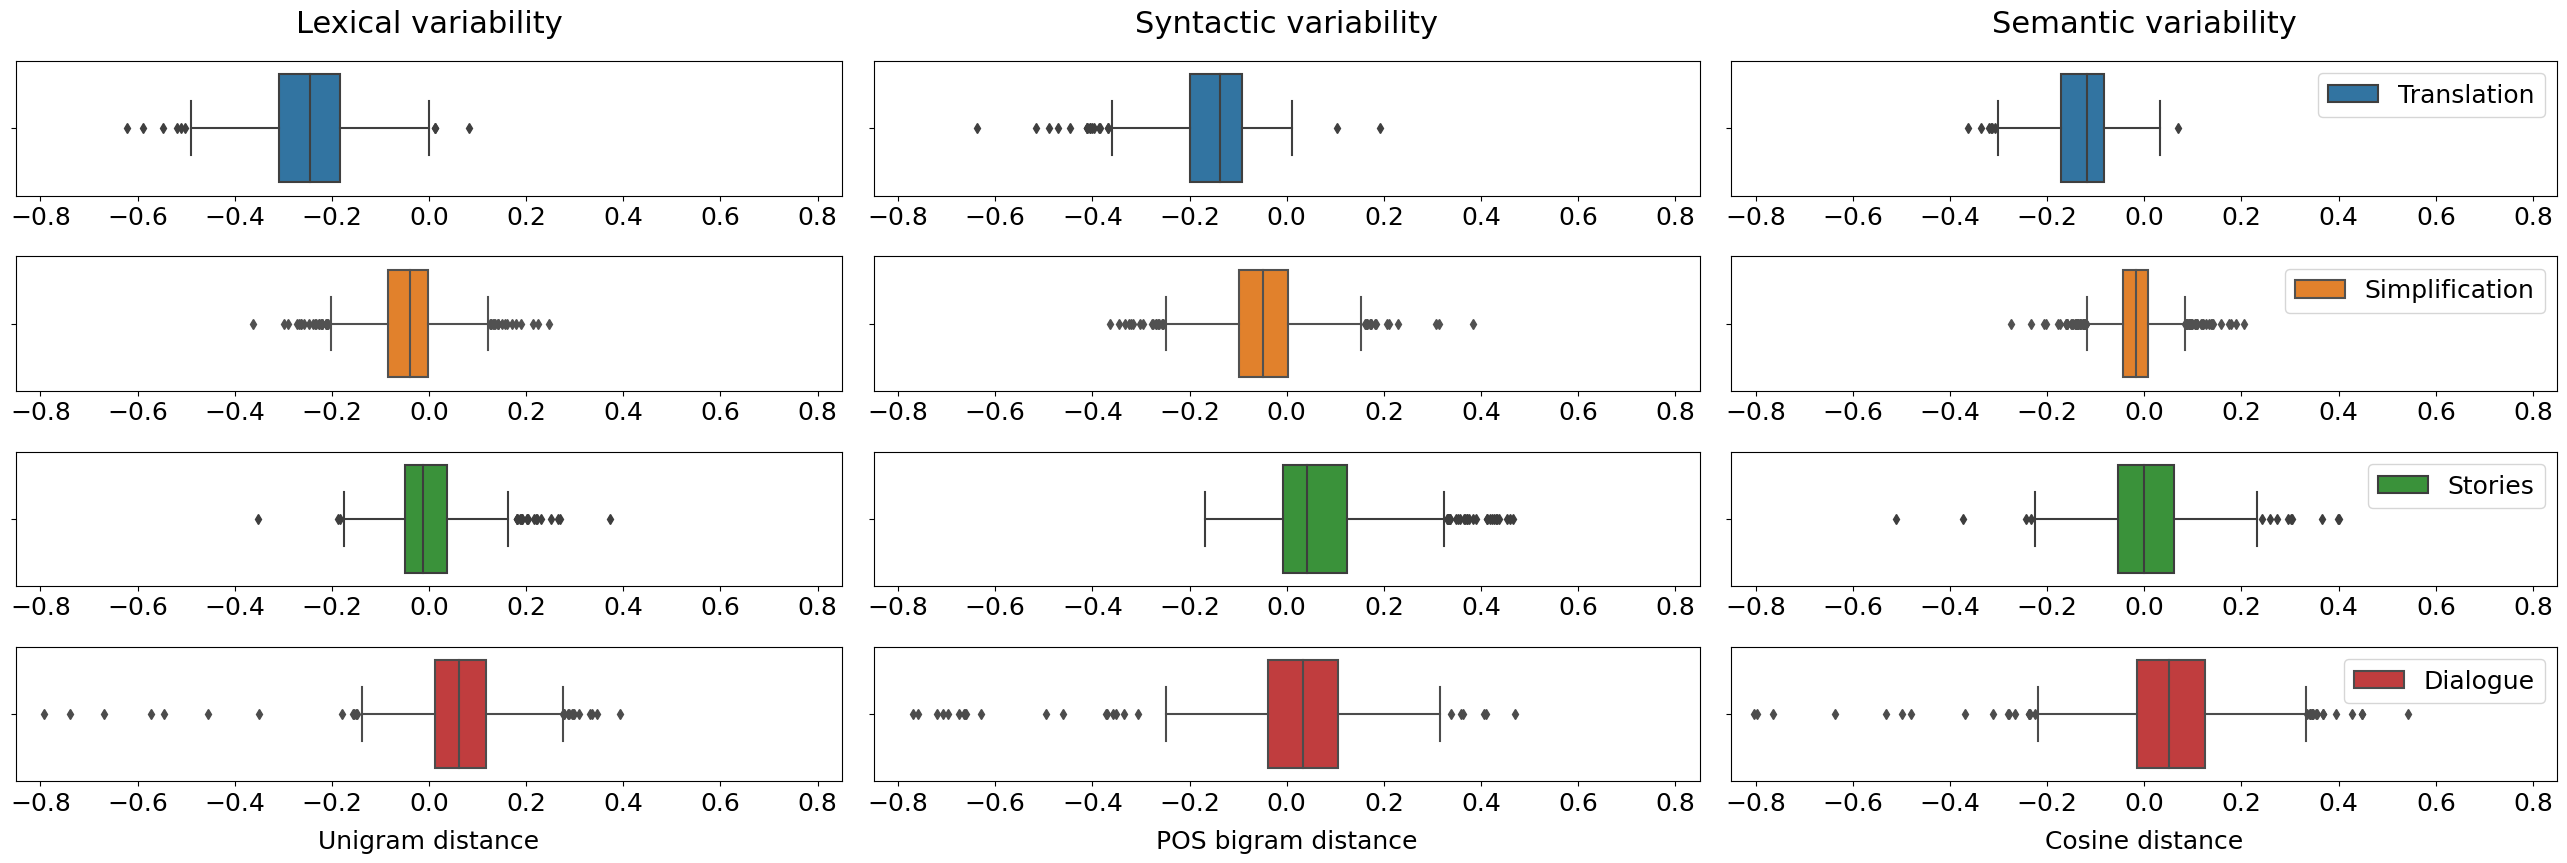

In [37]:
plot_mean_difference_dist(df_divergences['self'], f'{plot_dir}/mean_diff_self.png')

### Figure 8

/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mario/miniconda3/envs/nlg-uncertainty-probes-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1

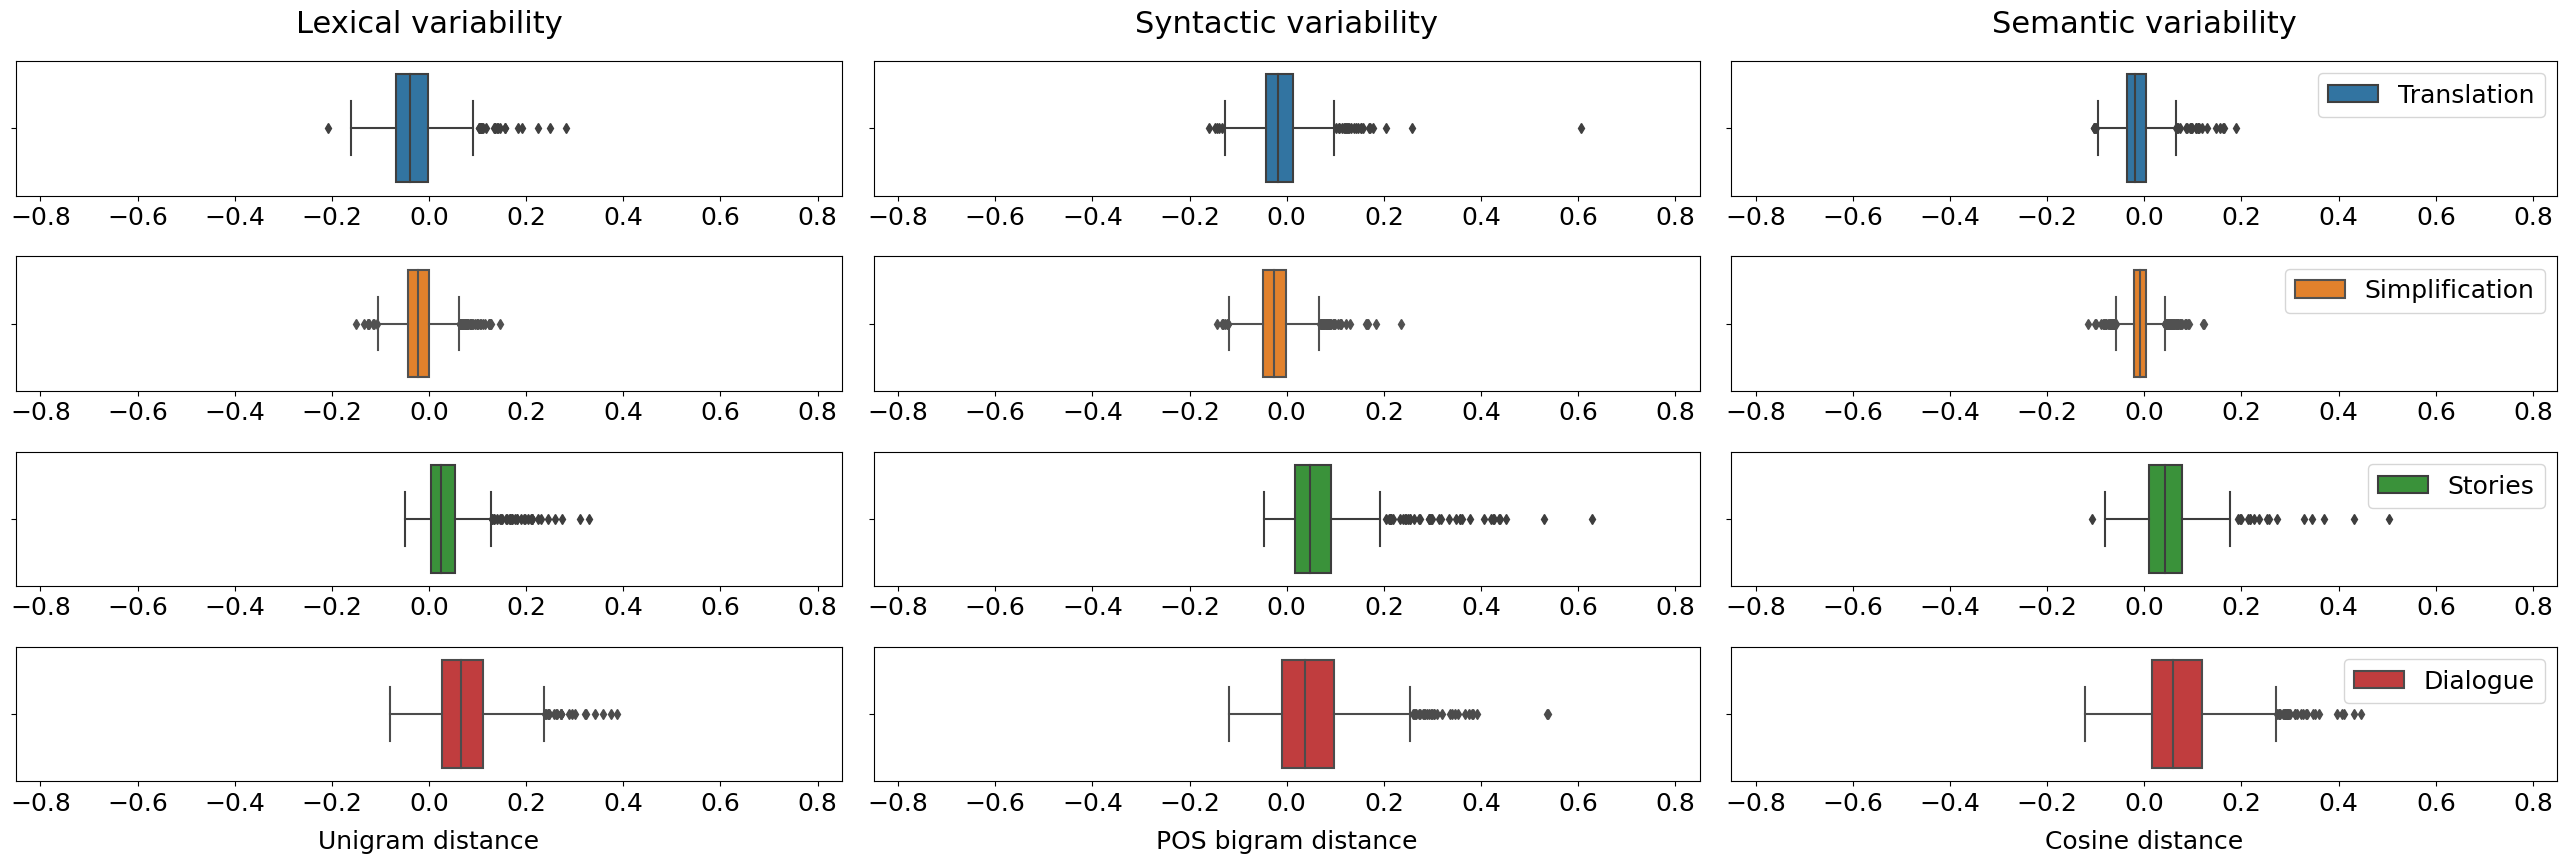

In [38]:
plot_mean_difference_dist(df_divergences['cross'], f'{plot_dir}/mean_diff_cross.png')

----